

# Fully Convolutional Neural Networks

# Dataset
The given dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. We will be using only 7000 of the 20,000 images. The dataset in this assignment is going to be used for the following task:

##Given the pixels of an image, perform age estimation, ethnicity classification and gender classification for the image using a single neural network.


The dataset for this assignment is already cleaned and provided in a CSV format for you with images included as pixel values.

The 4 columns contain the following information:

* **[age]** is an integer from 0 to 116, indicating the age. You can convert it to float for regression predictions
* **[gender]** is either 0 (male) or 1 (female)
* **[race]** is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
*  The 4th column contains the pixels of the images flattened to a single dimension. Each of the original image is of size 48x48 and the flattened image vector consists of 48x48 = 2304 pixel values.



In [131]:
!gdown https://drive.google.com/file/d/1_KRWsOhQNf6BZcdu4pg2JVy-lHo7_Cno/view?usp=sharing --fuzzy

In [7]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# Lets use pandas to load our data
df = pandas.read_csv("DL_assignment1_dataset.csv")
df

,age,ethnicity,gender,pixels
0,1,2,0,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,202 205 209 210 209 209 210 211 212 214 218 21...
...,...,...,...,...
23700,99,0,1,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701,99,1,1,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702,99,2,1,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703,99,2,1,45 108 120 156 206 197 140 180 191 199 204 207...


### For this assignment we will be using fully connected neural networks and hence to keep things simple we will only use 7000 of the ~20000 images for quick training times.

### Please do not change the seed for the sampling of data points.

In [9]:
random_seed = 42
df_sampled = df.sample(n=7000, random_state=random_seed)
df_sampled.reset_index(drop=True, inplace=True)
df_sampled

,age,ethnicity,gender,pixels
0,49,1,1,31 32 28 27 34 38 37 40 47 51 52 57 72 93 118 ...
1,39,1,0,186 65 38 40 36 51 64 64 60 55 58 60 73 79 82 ...
2,8,4,0,20 23 35 34 45 65 69 72 79 92 106 115 134 148 ...
3,40,4,0,6 6 13 19 15 23 41 76 106 125 133 138 152 158 ...
4,27,0,0,31 31 29 51 98 136 162 175 176 178 178 179 184...
...,...,...,...,...
6995,49,3,0,128 130 131 131 132 134 134 140 72 43 102 77 1...
6996,28,1,1,28 22 19 23 16 22 19 31 64 81 88 96 108 120 13...
6997,32,3,1,221 229 227 200 166 115 146 198 186 184 178 15...
6998,41,0,0,58 61 76 58 83 71 74 90 71 112 77 91 111 135 1...


Let us take a look at an image. You will get an idea of how to process your data for your neural network.

The 4th column contains all the pixel values in a string for each image. Lets convert all the strings to arrays first.

In [10]:
def string_to_array(pixel_string):
    pixel_list = pixel_string.split()
    pixel_array = np.array([int(value) for value in pixel_list])
    return pixel_array

In [11]:
df_sampled['pixels'] = df_sampled['pixels'].apply(string_to_array)

In [12]:
df_sampled['pixels']

0       [31, 32, 28, 27, 34, 38, 37, 40, 47, 51, 52, 5...
1       [186, 65, 38, 40, 36, 51, 64, 64, 60, 55, 58, ...
2       [20, 23, 35, 34, 45, 65, 69, 72, 79, 92, 106, ...
3       [6, 6, 13, 19, 15, 23, 41, 76, 106, 125, 133, ...
4       [31, 31, 29, 51, 98, 136, 162, 175, 176, 178, ...
                              ...                        
6995    [128, 130, 131, 131, 132, 134, 134, 140, 72, 4...
6996    [28, 22, 19, 23, 16, 22, 19, 31, 64, 81, 88, 9...
6997    [221, 229, 227, 200, 166, 115, 146, 198, 186, ...
6998    [58, 61, 76, 58, 83, 71, 74, 90, 71, 112, 77, ...
6999    [19, 21, 20, 23, 33, 54, 90, 128, 149, 169, 17...
Name: pixels, Length: 7000, dtype: object

Our "pixels" column has been converted to arrays which we can now use as input features to our model

Lets show the first image of our dataset

Age: 28
Ethnicity: 3
Gender: 0


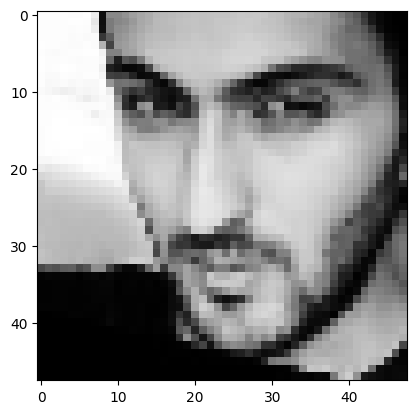

In [13]:
index = 30
first_image = df_sampled['pixels'][index]
image = first_image.reshape((48,48))
print("Age: "+str(df_sampled["age"][index])+"\nEthnicity: "+str(df_sampled["ethnicity"][index])+ "\nGender: "+str(df_sampled["gender"][index]))
plt.imshow(image,cmap="gray")

Uptill now, an initial processing has already been done using pandas in this starter code jupyter notebook. Hence you have a data frame ready for your assignment.

Please use the dataframe "df_sampled" for your assignment.

# You should consult the Assignment 1 document provided to you on LMS  for information regarding the tasks that are needed to be done for successful completion of this assignment. Grading rubricks are also mentioned in detail there.



In [3]:
# Write any further imports you need here
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.optim as optim


In [15]:
# separate features and labels
features = df_sampled['pixels'].values
labels = df_sampled['ethnicity'].values

# convert features and labels to torch tensors
features = [np.array(f) for f in features] # numpy array of features
features = torch.tensor(features, dtype=torch.float64)
features = features / 255.0

# since three tasks three labels


gender_labels = torch.tensor(df_sampled['gender'].values, dtype=torch.int64)
age_labels = torch.tensor(df_sampled['age'].values, dtype=torch.float64)
ethnicity_labels = torch.tensor(df_sampled['ethnicity'].values, dtype=torch.int64)

dataset = TensorDataset(features, ethnicity_labels, age_labels, gender_labels)




# split dataset into train, test and validation sets
train_size = int(0.7 * len(dataset))
test_size = int(0.15 * len(dataset))
val_size = len(dataset) - train_size - test_size

# randomly split dataset into train, test and validation sets

train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])
# print number of samples in each set
print("Number of samples in train set: ", len(train_dataset))
print("Number of samples in test set: ", len(test_dataset))
print("Number of samples in validation set: ", len(val_dataset))

batch_size = 64

# create a data loader for train and test sets
# since we have three tasks we can collate the data in the data loader

def collate(batch):
    images = torch.stack([item[0] for item in batch])
    ethnicity = torch.stack([item[1] for item in batch])
    age = torch.stack([item[2] for item in batch])
    gender = torch.stack([item[3] for item in batch])

    return images, ethnicity, age, gender


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate)

Number of samples in train set:  4900
Number of samples in test set:  1050
Number of samples in validation set:  1050


C:\Users\mujtaba\AppData\Local\Temp\ipykernel_54116\173183823.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  features = torch.tensor(features, dtype=torch.float64)


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        # shared Layers
        self.shared = nn.Sequential(
            nn.Linear(2304, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Dropout(0.5)
        )
        
        # age Head
        self.age_head = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

        # gender Head
        self.gender_head = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )

        # ethnicity Head
        self.ethnicity_head = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 5)
        )

    def forward(self, x):
        x = self.shared(x)
        return {
            'age': self.age_head(x),
            'gender': self.gender_head(x),
            'ethnicity': self.ethnicity_head(x)
        }
sample_model = Classifier()
sample_model

Classifier(
  (shared): Sequential(
    (0): Linear(in_features=2304, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.5, inplace=False)
  )
  (age_head): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.5, inplace=False)
   

In [142]:

def print_stats(epoch, train_summary, val_summary):
    """print training and validation metrics for each epoch."""
    print('\n')
    print('epoch: {} \t'.format(epoch + 1))
    for name, value in train_summary.items():
        print('{} - train: {:.6f} \tval: {:.6f}'.format(name, value, val_summary[name]))
    print('\n\n')


def plot_results(train_metrics, val_metrics):
    """plot training and validation metrics."""
    metrics = list(train_metrics.keys())
    for metric in metrics:
        plt.figure(figsize=(12, 4))
        plt.plot(train_metrics[metric], label='train')
        plt.plot(val_metrics[metric], label='val')
        plt.title(metric)
        plt.legend()
        plt.xlabel('epoch')
        plt.show()


In [143]:
def run_epoch(dataloader, model, optimizer, gender_criterion, age_criterion, ethnicity_criterion, train):
    """run an epoch and return the metrics."""
    running_metrics = {
        'total_loss': 0,
        'gender_loss': 0, 
        'ethnicity_loss': 0, 
        'age_loss': 0, 
        'gender_correct': 0, 
        'ethnicity_correct': 0, 
        'total': 0
    }
    
    for inputs, ethnicity, age, gender in dataloader:
        outputs = model(inputs)
        
        # calculate loss
        gender_loss = gender_criterion(outputs['gender'], gender)
        ethnicity_loss = ethnicity_criterion(outputs['ethnicity'], ethnicity)
        age_loss = age_criterion(outputs['age'].view(-1), age)
        
        # weighted loss as age loss is much higher than other losses
        total_loss = gender_loss + ethnicity_loss + 0.0001 * age_loss
        
        if train:
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        _, gender_preds = torch.max(outputs['gender'], 1)
        _, ethnicity_preds = torch.max(outputs['ethnicity'], 1)

        # update metrics
        running_metrics['total_loss'] += total_loss.item()
        running_metrics['gender_loss'] += gender_loss.item()
        running_metrics['ethnicity_loss'] += ethnicity_loss.item()
        running_metrics['age_loss'] += age_loss.item()
        running_metrics['gender_correct'] += (gender_preds == gender).sum().item()
        running_metrics['ethnicity_correct'] += (ethnicity_preds == ethnicity).sum().item()
        running_metrics['total'] += gender.size(0)
        
    epoch_metrics = {
        'total_loss': running_metrics['total_loss'] / len(dataloader),
        'gender_loss': running_metrics['gender_loss'] / len(dataloader),
        'ethnicity_loss': running_metrics['ethnicity_loss'] / len(dataloader),
        'age_loss': running_metrics['age_loss'] / len(dataloader),
        'gender_accuracy': (running_metrics['gender_correct'] / running_metrics['total']) * 100,
        'ethnicity_accuracy': (running_metrics['ethnicity_correct'] / running_metrics['total']) * 100
    }
    
    return epoch_metrics


In [144]:
def train_model(num_epochs, model, optimizer, train_dl, val_dl, gender_criterion, age_criterion, ethnicity_criterion):
    """train and validate the model, then plot results."""
    min_loss = 9999999
    # initialize lists to store metrics
    train_losses, val_losses = [], []
    train_metrics, val_metrics = {}, {}
    metrics = ['total_loss','gender_loss', 'ethnicity_loss', 'age_loss', 'gender_accuracy', 'ethnicity_accuracy']
    
    for m in metrics:
        train_metrics[m], val_metrics[m] = [], []
    
    for epoch in range(num_epochs):
        # training phase
        model.train()
        train_summary = run_epoch(train_dl, model, optimizer, gender_criterion, age_criterion, ethnicity_criterion, train=True)
        for m in metrics:
            train_metrics[m].append(train_summary[m])
        
        if(train_summary['total_loss'] < min_loss):
            min_loss = train_summary['total_loss']
            torch.save(model, 'model.pt')

        # validation phase
        model.eval()
        with torch.no_grad():
            val_summary = run_epoch(val_dl, model, optimizer, gender_criterion, age_criterion, ethnicity_criterion, train=False)
            for m in metrics:
                val_metrics[m].append(val_summary[m])

        # print stats
        print_stats(epoch, train_summary, val_summary)
        
    plot_results(train_metrics, val_metrics)



epoch: 1 	
total_loss - train: 2.357671 	val: 2.077262
gender_loss - train: 0.665768 	val: 0.567175
ethnicity_loss - train: 1.541605 	val: 1.363628
age_loss - train: 1502.986245 	val: 1464.590735
gender_accuracy - train: 60.755102 	val: 71.714286
ethnicity_accuracy - train: 34.979592 	val: 52.285714





epoch: 2 	
total_loss - train: 2.069348 	val: 1.829057
gender_loss - train: 0.583014 	val: 0.495859
ethnicity_loss - train: 1.341741 	val: 1.192236
age_loss - train: 1445.932112 	val: 1409.618138
gender_accuracy - train: 69.714286 	val: 74.952381
ethnicity_accuracy - train: 48.244898 	val: 54.000000





epoch: 3 	
total_loss - train: 1.909949 	val: 1.683885
gender_loss - train: 0.527367 	val: 0.429624
ethnicity_loss - train: 1.244340 	val: 1.120911
age_loss - train: 1382.417221 	val: 1333.494225
gender_accuracy - train: 73.897959 	val: 78.761905
ethnicity_accuracy - train: 51.918367 	val: 57.904762





epoch: 4 	
total_loss - train: 1.749550 	val: 1.557653
gender_loss - train: 0.45

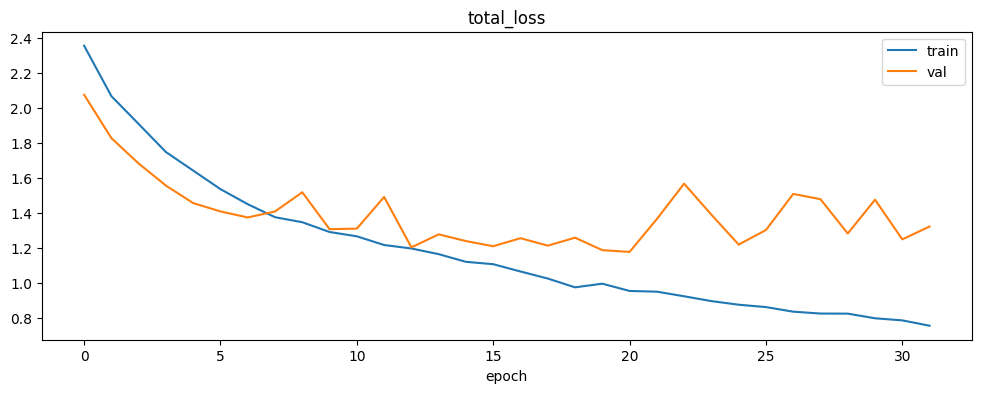

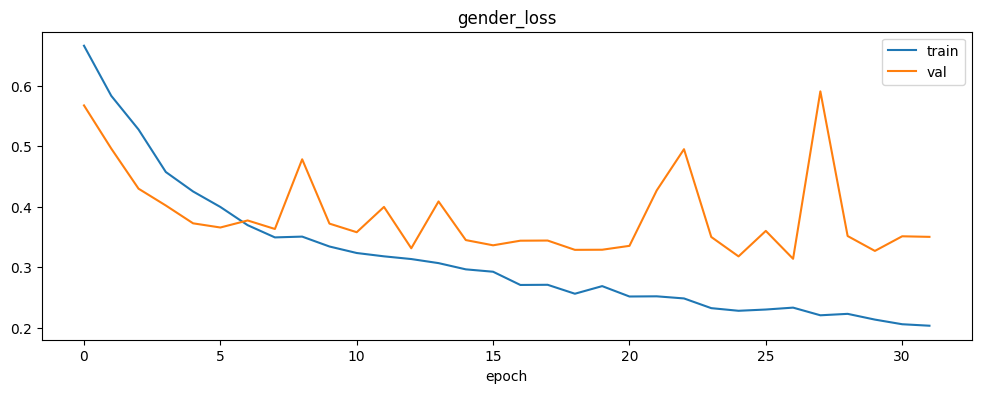

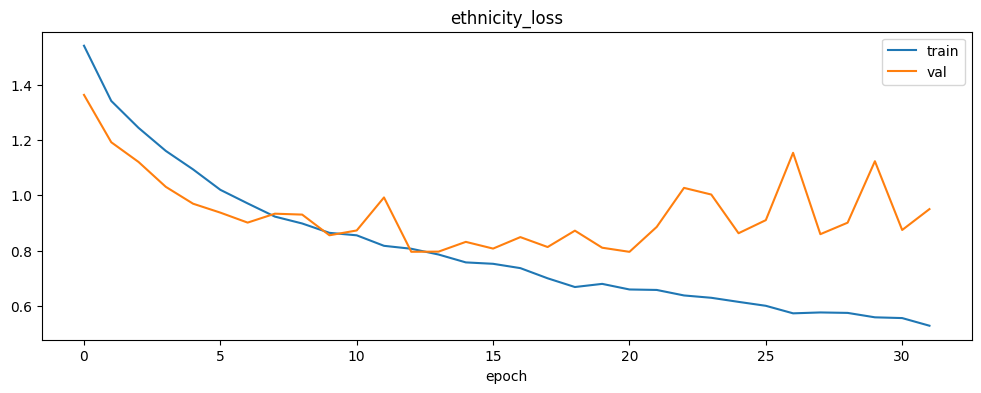

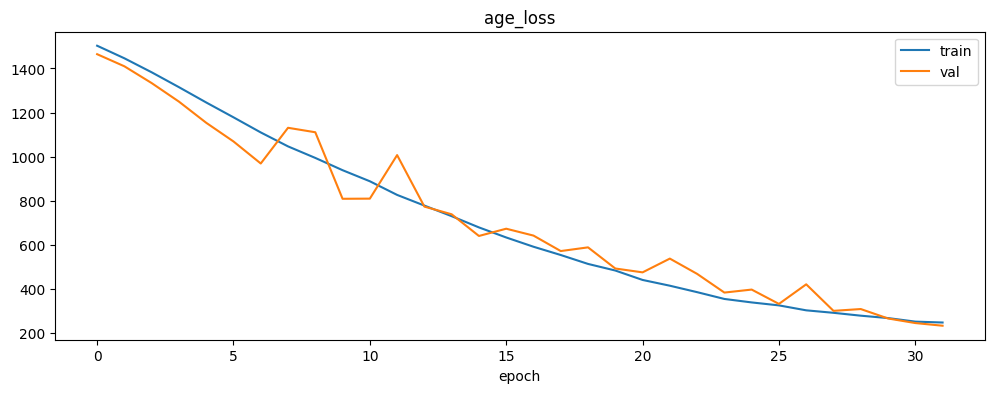

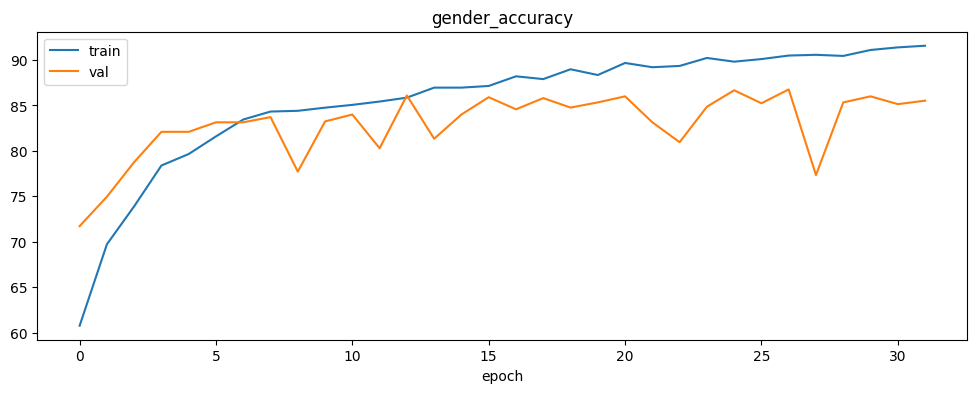

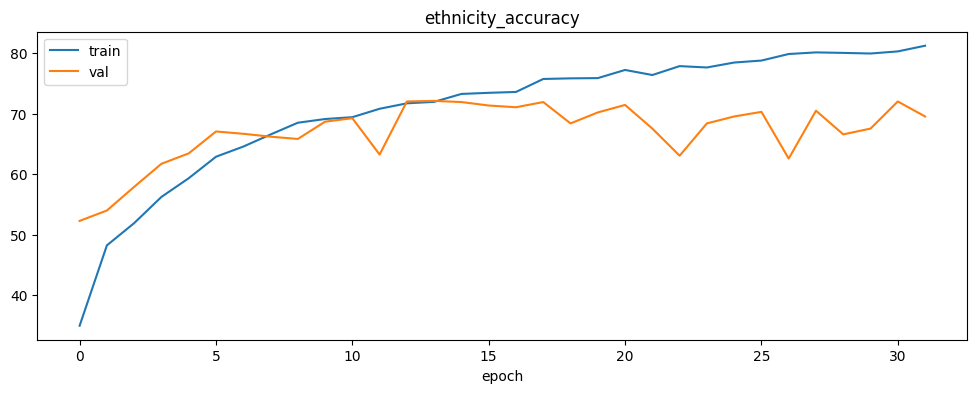

In [145]:
# setting up and training the model
num_epochs = 32
lr = 0.0001

model = Classifier()
model.to(torch.float64)

# loss functions and optimizer
gender_criterion = nn.CrossEntropyLoss()
age_criterion = nn.MSELoss()
ethnicity_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_model(num_epochs, model, optimizer, train_loader, val_loader, gender_criterion, age_criterion, ethnicity_criterion)

In [18]:
def predict(model, test_loader):
    model.eval()
    age_preds = []
    ethnicity_preds = []
    gender_preds = []
    age_true = []
    ethnicity_true = []
    gender_true = []

    with torch.no_grad():
        for inputs, ethnicity, age, gender in test_loader:
            outputs = model(inputs)
            
            age_preds.extend(outputs['age'].tolist())
            ethnicity_preds.extend(torch.argmax(outputs['ethnicity'], dim=1).tolist())
            gender_preds.extend(torch.argmax(outputs['gender'], dim=1).tolist())

            age_true.extend(age.tolist())
            ethnicity_true.extend(ethnicity.tolist())
            gender_true.extend(gender.tolist())

    return age_preds, ethnicity_preds, gender_preds, age_true, ethnicity_true, gender_true


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, ConfusionMatrixDisplay

def evaluate(model, test_loader):
    age_preds, ethnicity_preds, gender_preds, age_true, ethnicity_true, gender_true = predict(model, test_loader)

    # compute confusion matrices
    ethnicity_cm = confusion_matrix(ethnicity_true, ethnicity_preds)
    gender_cm = confusion_matrix(gender_true, gender_preds)

    # compute MSE for Age regression task
    age_mse = mean_squared_error(age_true, age_preds)

    # compute accuracies for classification tasks
    ethnicity_acc = accuracy_score(ethnicity_true, ethnicity_preds)
    gender_acc = accuracy_score(gender_true, gender_preds)

    # plot confusion matrices
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # ethnicity Confusion Matrix
    ConfusionMatrixDisplay(ethnicity_cm).plot(ax=ax[0], cmap=plt.cm.Blues)
    ax[0].set_title("Ethnicity Confusion Matrix")
    
    # gender Confusion Matrix
    ConfusionMatrixDisplay(gender_cm).plot(ax=ax[1], cmap=plt.cm.Blues)
    ax[1].set_title("Gender Confusion Matrix")

    plt.show()

    print("Age MSE:", age_mse)
    print("Ethnicity Accuracy:", ethnicity_acc)
    print("Gender Accuracy:", gender_acc)

    return ethnicity_cm, gender_cm, age_mse, ethnicity_acc, gender_acc


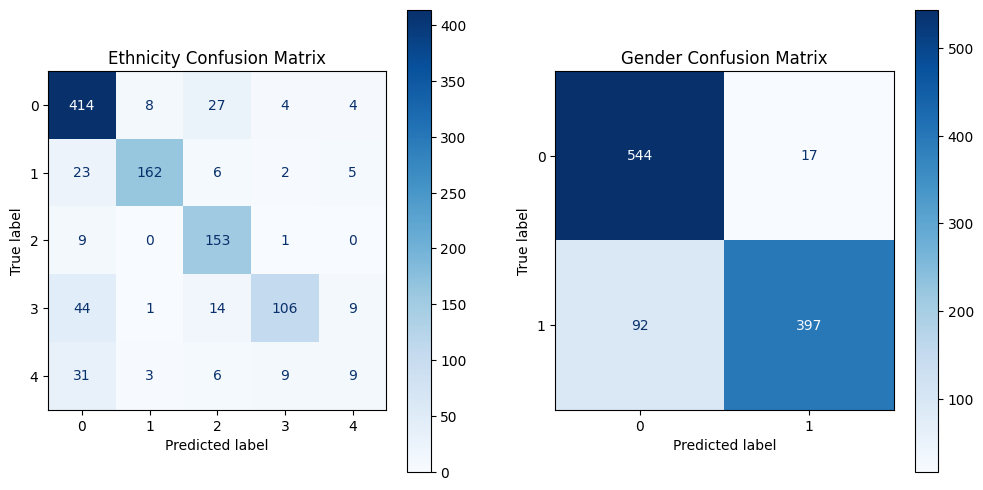

Age MSE: 214.6785971502372
Ethnicity Accuracy: 0.8038095238095239
Gender Accuracy: 0.8961904761904762


In [23]:
loaded_model = torch.load('model.pt')
loaded_model.eval()
ethnicity_cm, gender_cm, age_mse, ethnicity_acc, gender_acc = evaluate(loaded_model, test_loader)
